# Building Models for eCommerce Fraud Detection

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)


# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading

The datasets into PySpark DataFrames and used DataFrame functions to process the data.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

# Configure the SparkConf with the required settings.
conf = SparkConf() \
    .setAppName("eCommerce Fraud Detection") \
    .setMaster("local[*]") \
    .set("spark.sql.files.maxPartitionBytes", "16MB") \
    .set("spark.driver.memory", "4g") \
    .set("spark.executor.memory", "4g")

# Create SparkSession with the custom configuration.
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print Spark memory settings to verify them.
print("Driver Memory: ", spark.conf.get("spark.driver.memory"))
print("Executor Memory: ", spark.conf.get("spark.executor.memory"))
print("Max Partition Bytes: ", spark.conf.get("spark.sql.files.maxPartitionBytes"))


Driver Memory:  4g
Executor Memory:  4g
Max Partition Bytes:  16MB


In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType

# Customer Schema
customer_schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", DateType(), True),
    StructField("first_join_date", DateType(), True)
])

# Category Schema
category_schema = StructType([
    StructField("category_id", IntegerType(), True),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True)
])

# Browsing Behavior Schema
browsing_schema = StructType([
    StructField("session_id", StringType(), True),
    StructField("event_type", StringType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("traffic_source", StringType(), True),
    StructField("device_type", StringType(), True)
])

# Product Schema
product_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", IntegerType(), True)
])

# Transaction Schema
transaction_schema = StructType([
    StructField("created_at", TimestampType(), True),
    StructField("customer_id", IntegerType(), True),
    StructField("transaction_id", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", DoubleType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", DoubleType(), True),
    StructField("shipment_location_lat", DoubleType(), True),
    StructField("shipment_location_long", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("clear_payment", StringType(), True)
])

# Customer Session Schema
customer_session_schema = StructType([
    StructField("session_id", StringType(), True),
    StructField("customer_id", IntegerType(), True)
])

# Fraud Transaction Schema
fraud_transaction_schema = StructType([
    StructField("transaction_id", StringType(), True),
    StructField("Is_fraud", StringType(), True)
])


In [3]:
# Loading CSV Files with verified paths.
category_df = spark.read.csv("category.csv", schema=category_schema, header=True)
customer_df = spark.read.csv("customer.csv", schema=customer_schema, header=True)
product_df = spark.read.csv("product.csv", schema=product_schema, header=True)
browsing_df = spark.read.csv("browsing_behaviour.csv", schema=browsing_schema, header=True)
transaction_df = spark.read.csv("transactions.csv", schema=transaction_schema, header=True)
customer_session_df = spark.read.csv("customer_session.csv", schema=customer_session_schema, header=True)
fraud_transaction_df = spark.read.csv("fraud_transaction.csv", schema=fraud_transaction_schema, header=True)

# To print the schemas and show some data to verify
customer_df.printSchema()
category_df.printSchema()
browsing_df.printSchema()
product_df.printSchema()
transaction_df.printSchema()
customer_session_df.printSchema()
fraud_transaction_df.printSchema()

# To show some rows for verification
customer_df.show(5)
category_df.show(5)
browsing_df.show(5)
product_df.show(5)
transaction_df.show(5)
customer_session_df.show(5)
fraud_transaction_df.show(5)

root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- first_join_date: date (nullable = true)

root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)

root
 |-- session_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- device_type: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- usage: string (nullable = true)
 |-- productDisplayName: string (nul

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the browsing behaviour dataset, there are 10 types of events:  
VC(Viewing Category), VI(Viewing Item), VP(Viewing Promotion), AP(Add Promotion), CL(Click on a product/category) , ATC(Add a product to Shopping Cart), CO(CheckOut), HP(View HomePage), SCR(Mouse Scrolling), SER(Search for a product/category)  
We categorise them into three different levels:  
L1(actions that are highly likely lead to a purchase): AP, ATC, CO  
L2(actions may lead to purchase): VC, VP, VI, SER  
L3(not very important - just browsing):  SCR, HP, CL  
  

In [4]:
from pyspark.sql import functions as F

# Defining the mappings for L1, L2, and L3 levels
l1_actions = ['AP', 'ATC', 'CO']
l2_actions = ['VC', 'VP', 'VI', 'SER']
l3_actions = ['SCR', 'HP', 'CL']

# To filter and count the events for each level for each session
feature_df = browsing_df.groupBy("session_id") \
    .agg(
        F.sum(F.when(F.col("event_type").isin(l1_actions), 1).otherwise(0)).alias("L1_count"),
        F.sum(F.when(F.col("event_type").isin(l2_actions), 1).otherwise(0)).alias("L2_count"),
        F.sum(F.when(F.col("event_type").isin(l3_actions), 1).otherwise(0)).alias("L3_count")
    )

# To display the transformed data with new columns
feature_df.show(truncate=False)

+------------------------------------+--------+--------+--------+
|session_id                          |L1_count|L2_count|L3_count|
+------------------------------------+--------+--------+--------+
|2be2c406-4fe3-455a-9c12-14d7286f218c|2       |0       |5       |
|5e2f9306-77d9-4eec-8be9-db41ea8d0250|2       |2       |7       |
|efb5e1c0-f66e-49e3-8b5c-171f078c0717|4       |1       |2       |
|79fb5117-34c6-4346-8cc1-ab0dbe59fea5|3       |1       |2       |
|8674e10b-271b-4be7-919b-17764367ffce|4       |4       |13      |
|6859c444-7d72-4a0d-a1e3-09554ef32056|3       |1       |3       |
|4f0e460f-b8b2-4360-bb87-3596b43472c7|5       |16      |24      |
|721a63c1-90a9-4e55-b6e6-21e98daa206b|13      |8       |9       |
|41289ace-60e5-436a-9cc1-5fc077f09f12|2       |0       |2       |
|c12fa8b4-e71e-4135-bbcd-adc490ac39d6|9       |11      |12      |
|e2e4fcd3-da31-4ca2-9765-75e294b682cc|2       |6       |21      |
|3f165acd-8646-49cd-9da0-c545a435b033|3       |6       |22      |
|337fc58a-

In [5]:
# To Add the ratio columns: L1_ratio and L2_ratio with rounding to 2 decimal places
feature_df = feature_df.withColumn(
    "total_actions", F.col("L1_count") + F.col("L2_count") + F.col("L3_count")
).withColumn(
    "L1_ratio", F.round(F.when(F.col("total_actions") > 0, (F.col("L1_count") / F.col("total_actions")) * 100).otherwise(0), 2)
).withColumn(
    "L2_ratio", F.round(F.when(F.col("total_actions") > 0, (F.col("L2_count") / F.col("total_actions")) * 100).otherwise(0), 2)
)

# Removing the total_actions column as it is not needed for further analysis
feature_df = feature_df.drop("total_actions")

# Show the results
feature_df.show(truncate=False)

+------------------------------------+--------+--------+--------+--------+--------+
|session_id                          |L1_count|L2_count|L3_count|L1_ratio|L2_ratio|
+------------------------------------+--------+--------+--------+--------+--------+
|2be2c406-4fe3-455a-9c12-14d7286f218c|2       |0       |5       |28.57   |0.0     |
|5e2f9306-77d9-4eec-8be9-db41ea8d0250|2       |2       |7       |18.18   |18.18   |
|efb5e1c0-f66e-49e3-8b5c-171f078c0717|4       |1       |2       |57.14   |14.29   |
|79fb5117-34c6-4346-8cc1-ab0dbe59fea5|3       |1       |2       |50.0    |16.67   |
|8674e10b-271b-4be7-919b-17764367ffce|4       |4       |13      |19.05   |19.05   |
|6859c444-7d72-4a0d-a1e3-09554ef32056|3       |1       |3       |42.86   |14.29   |
|4f0e460f-b8b2-4360-bb87-3596b43472c7|5       |16      |24      |11.11   |35.56   |
|721a63c1-90a9-4e55-b6e6-21e98daa206b|13      |8       |9       |43.33   |26.67   |
|41289ace-60e5-436a-9cc1-5fc077f09f12|2       |0       |2       |50.0    |0.

In [6]:
# Define UDF to convert hour to time of day group
def time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

# To register the UDF
time_of_day_udf = F.udf(time_of_day, StringType())

# To extract the hour from the event_time
browsing_df = browsing_df.withColumn("event_hour", F.hour("event_time"))

# To calculate the average hour for each session and round to 2 decimal points
avg_event_time_df = browsing_df.groupBy("session_id").agg(F.round(F.avg("event_hour"), 2).alias("avg_event_hour"))

# Applying the UDF to categorize the average hour into time of day
avg_event_time_df = avg_event_time_df.withColumn("time_of_day", time_of_day_udf(F.col("avg_event_hour")))

# To join the time of day feature with the browsing_counts_with_ratios_df
feature_df = feature_df.join(avg_event_time_df, on="session_id", how="left")

# To print the feature DataFrame
print(feature_df.show(20))

+--------------------+--------+--------+--------+--------+--------+--------------+-----------+
|          session_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|avg_event_hour|time_of_day|
+--------------------+--------+--------+--------+--------+--------+--------------+-----------+
|0860887f-7154-492...|       3|       0|       1|    75.0|     0.0|          19.0|    evening|
|16480c27-7223-46b...|      10|       5|       8|   43.48|   21.74|          9.91|    morning|
|1e19b0cd-b634-4b1...|       3|       0|       6|   33.33|     0.0|         10.56|    morning|
|2be2c406-4fe3-455...|       2|       0|       5|   28.57|     0.0|          9.86|    morning|
|337fc58a-b6fb-41b...|       2|       1|      10|   15.38|    7.69|         13.31|  afternoon|
|3f165acd-8646-49c...|       3|       6|      22|    9.68|   19.35|         12.03|  afternoon|
|41289ace-60e5-436...|       2|       0|       2|    50.0|     0.0|         12.75|  afternoon|
|4f0e460f-b8b2-436...|       5|      16|      24| 

In [7]:
# To calculate the current year for age calculation
current_year = F.year(F.current_date())

# To join feature_df with customer_session_df to get customer_id
feature_df = feature_df.join(customer_session_df.select("session_id", "customer_id"), on="session_id", how="left")

# Joining the datd frame with customer_df to get gender, birthdate, and first_join_year
# To calculate age and first_join_year during the join to avoid extra column manipulations
feature_df = feature_df.join(
    customer_df.select("customer_id", "gender", "birthdate", "first_join_date")
    .withColumn("age", (current_year - F.year("birthdate")).cast(IntegerType()))
    .withColumn("first_join_year", F.year("first_join_date")),
    on="customer_id",
    how="left"
)

# To join with transaction_df using session_id to get the geolocation
# Directly combining the latitude and longitude into the geolocation field during the join
feature_df = feature_df.join(
    transaction_df.select("session_id", "shipment_location_lat", "shipment_location_long")
    .withColumn("geolocation", F.concat_ws(", ", F.col("shipment_location_lat"), F.col("shipment_location_long"))),
    on="session_id",
    how="left"
)

# To select the final columns, no need for customer_id anymore
final_columns = [
    "session_id", "L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "time_of_day", 
    "gender", "age", "geolocation", "first_join_year"
]
feature_df = feature_df.select(final_columns)

# To print the feature DataFrame
feature_df.show(truncate=False)


+------------------------------------+--------+--------+--------+--------+--------+-----------+------+---+-----------------------------------+---------------+
|session_id                          |L1_count|L2_count|L3_count|L1_ratio|L2_ratio|time_of_day|gender|age|geolocation                        |first_join_year|
+------------------------------------+--------+--------+--------+--------+--------+-----------+------+---+-----------------------------------+---------------+
|0860887f-7154-4922-8ba3-033c0f1e462c|3       |0       |1       |75.0    |0.0     |evening    |M     |31 |-8.93647675428053, 117.516555869961|2018           |
|16480c27-7223-46bb-9fd3-fff64e9c8755|10      |5       |8       |43.48   |21.74   |morning    |F     |36 |3.73627773774994, 108.296456587667 |2019           |
|1e19b0cd-b634-4b11-881d-232304e44656|3       |0       |6       |33.33   |0.0     |morning    |F     |21 |-7.7929353132786, 111.181474470591 |2018           |
|2be2c406-4fe3-455a-9c12-14d7286f218c|2       

In [8]:
# To join feature_df with customer_session_df to retrieve customer_id based on session_id
feature_df = feature_df.join(customer_session_df.select("session_id", "customer_id"), on="session_id", how="left")

# To count the number of purchases per session in transaction_df
# To aggregate based on session_id because transactions are linked with session_id
purchase_counts = transaction_df.groupBy("session_id") \
    .agg(F.count("transaction_id").alias("purchase_count"))

# To join the purchase counts with customer_session_df to get customer-level purchase count
# To join with customer_session_df first to propagate customer_id, then group by customer_id
customer_purchase_counts = customer_session_df.join(purchase_counts, on="session_id", how="left") \
    .groupBy("customer_id") \
    .agg(F.sum("purchase_count").alias("num_purchases"))

# To join the aggregated customer-level purchase count with feature_df based on customer_id
feature_df = feature_df.join(customer_purchase_counts, on="customer_id", how="left")

# Filling the missing values in 'num_purchases' with 0 for customers with no purchases
feature_df = feature_df.fillna({"num_purchases": 0})

# To drop customer_id after the join as it is no longer needed
feature_df = feature_df.drop("customer_id")

# To print the feature DataFrame
feature_df.show(truncate=False)


+------------------------------------+--------+--------+--------+--------+--------+-----------+------+---+-----------------------------------+---------------+-------------+
|session_id                          |L1_count|L2_count|L3_count|L1_ratio|L2_ratio|time_of_day|gender|age|geolocation                        |first_join_year|num_purchases|
+------------------------------------+--------+--------+--------+--------+--------+-----------+------+---+-----------------------------------+---------------+-------------+
|6859c444-7d72-4a0d-a1e3-09554ef32056|3       |1       |3       |42.86   |14.29   |morning    |F     |28 |1.23382407146305, 116.936410549744 |2017           |39           |
|efb5e1c0-f66e-49e3-8b5c-171f078c0717|4       |1       |2       |57.14   |14.29   |morning    |F     |30 |-3.96992767945202, 104.099260262913|2021           |18           |
|56ead6e0-072a-41f2-b018-a35f3e039565|2       |3       |6       |18.18   |27.27   |morning    |M     |29 |-8.23067585425112, 111.750521

In [9]:
# To join `transaction_df` with `fraud_transaction_df` to attach fraud labels based on `transaction_id`
transaction_with_fraud = transaction_df.join(fraud_transaction_df, on="transaction_id", how="left")

# To aggregate fraud labels by session_id in the updated transaction DataFrame
# Note: If any transaction in a session is marked as fraud, label the session as 'fraud', otherwise 'non-fraud'
fraud_labels_by_session = transaction_with_fraud.groupBy("session_id") \
    .agg(F.max(F.when(F.col("Is_fraud") == "true", "fraud").otherwise("non-fraud")).alias("fraud_status"))

# To join fraud labels back to `feature_df` using `session_id`
feature_df = feature_df.join(fraud_labels_by_session, on="session_id", how="left")

# To fill missing values in `fraud_status` with 'non-fraud' (for sessions with no fraud transactions)
feature_df = feature_df.fillna({"fraud_status": "non-fraud"})

# To print the feature DataFrame
feature_df.show(truncate=False)


+------------------------------------+--------+--------+--------+--------+--------+-----------+------+---+-----------------------------------+---------------+-------------+------------+
|session_id                          |L1_count|L2_count|L3_count|L1_ratio|L2_ratio|time_of_day|gender|age|geolocation                        |first_join_year|num_purchases|fraud_status|
+------------------------------------+--------+--------+--------+--------+--------+-----------+------+---+-----------------------------------+---------------+-------------+------------+
|0860887f-7154-4922-8ba3-033c0f1e462c|3       |0       |1       |75.0    |0.0     |evening    |M     |31 |-8.93647675428053, 117.516555869961|2018           |39           |non-fraud   |
|16480c27-7223-46bb-9fd3-fff64e9c8755|10      |5       |8       |43.48   |21.74   |morning    |F     |36 |3.73627773774994, 108.296456587667 |2019           |23           |non-fraud   |
|1e19b0cd-b634-4b11-881d-232304e44656|3       |0       |6       |33.33

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>


In [10]:
from pyspark.sql import functions as F

# 1.3.1 a) Basic statistics for numeric columns
# Selecting all the numeric columns
numeric_columns = [col for col, dtype in feature_df.dtypes if dtype in ["int", "double", "float", "long"]]

# Using describe to compute basic statistics for numeric columns
numeric_stats_df = feature_df.select(numeric_columns).describe()

# Function to round specific rows (mean and stddev)
def round_describe_row(df, row_name, cols_to_round):
    for col in cols_to_round:
        df = df.withColumn(
            col, F.when(F.col("summary") == row_name, F.round(F.col(col).cast("double"), 2)).otherwise(F.col(col))
        )
    return df

# To apply rounding to 'mean' and 'stddev' rows
numeric_stats_rounded_df = round_describe_row(numeric_stats_df, "mean", numeric_columns)
numeric_stats_rounded_df = round_describe_row(numeric_stats_rounded_df, "stddev", numeric_columns)

# To show the final DataFrame with rounded means and stddevs
numeric_stats_rounded_df.show(truncate=False)


# Computing percentiles (25th, 50th, 75th) for numeric columns
percentiles = [0.25, 0.5, 0.75]
percentile_stats = {}
for col in numeric_columns:
    quantiles = feature_df.approxQuantile(col, percentiles, 0.01)
    percentile_stats[col] = dict(zip(["25%", "50%", "75%"], quantiles))

# To display percentile statistics with other stats
print("### Percentiles for Numeric Columns Below ###")
for col, stats in percentile_stats.items():
    print(f"{col}: 25% = {round(stats['25%'], 2)}, 50% = {round(stats['50%'], 2)}, 75% = {round(stats['75%'], 2)}")

# 1.3.1 b) Top-5 values for non-numeric columns
# Selecting all the non-numeric columns
non_numeric_columns = [col for col, dtype in feature_df.dtypes if dtype == "string"]

print("\n### Top-5 Values for Non-Numeric Columns ###")
# To display the top-5 values and their counts for each non-numeric column
for col in non_numeric_columns:
    print(f"Top-5 values for {col}:")
    feature_df.groupBy(col).count().orderBy(F.desc("count")).show(5, truncate=False)



+-------+--------+--------+------+---------------+
|summary|L1_ratio|L2_ratio|age   |first_join_year|
+-------+--------+--------+------+---------------+
|count  |701254  |701254  |665511|665511         |
|mean   |32.87   |19.32   |28.37 |2018.3         |
|stddev |19.19   |13.3    |7.29  |1.47           |
|min    |0.0     |0.0     |8     |2016           |
|max    |96.55   |83.33   |70    |2021           |
+-------+--------+--------+------+---------------+

### Percentiles for Numeric Columns Below ###
L1_ratio: 25% = 16.67, 50% = 33.33, 75% = 50.0
L2_ratio: 25% = 10.0, 50% = 20.0, 75% = 28.57
age: 25% = 23.0, 50% = 28.0, 75% = 33.0
first_join_year: 25% = 2017.0, 50% = 2018.0, 75% = 2019.0

### Top-5 Values for Non-Numeric Columns ###
Top-5 values for session_id:
+------------------------------------+-----+
|session_id                          |count|
+------------------------------------+-----+
|00035171-9b95-4404-8bd4-a1e46cb9baf6|1    |
|0007d60a-f3a1-4a5a-98b0-6634a6b751bb|1    |
|00

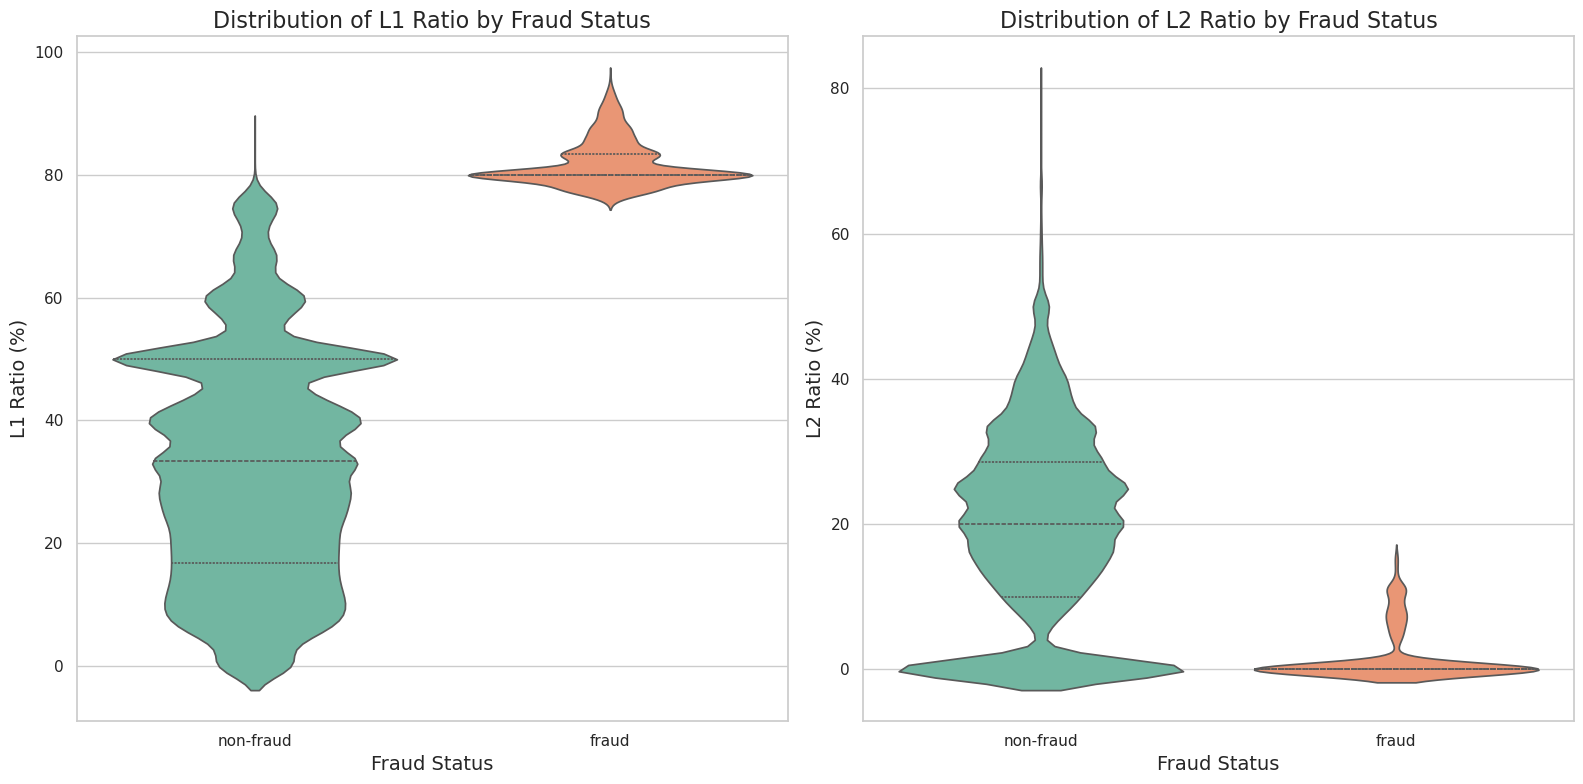

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample 10% of the data from feature dataframe to avoid performance issues
sampled_df = feature_df.sample(fraction=0.1, seed = 10)

# To select the necessary columns and drop missing values for 'L1_ratio', 'L2_ratio', and 'fraud_status'
filtered_df = sampled_df.select("L1_ratio", "L2_ratio", "fraud_status").dropna()

# To collect the data into a list of dictionaries for plotting (still keeping the scale small by sampling)
plot_data = filtered_df.collect()

# To prepare lists for each field from the collected data
l1_ratio = [row['L1_ratio'] for row in plot_data]
l2_ratio = [row['L2_ratio'] for row in plot_data]
fraud_status = [row['fraud_status'] for row in plot_data]

# To set up the figure for plotting
sns.set(style="whitegrid", palette="muted", color_codes=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# To create violin plots
sns.violinplot(x=fraud_status, y=l1_ratio, ax=ax1, hue=fraud_status, legend=False, palette="Set2", density_norm='width', inner='quartile')
ax1.set_title('Distribution of L1 Ratio by Fraud Status', fontsize=16)
ax1.set_xlabel('Fraud Status', fontsize=14)
ax1.set_ylabel('L1 Ratio (%)', fontsize=14)

sns.violinplot(x=fraud_status, y=l2_ratio, ax=ax2, hue=fraud_status, legend=False, palette="Set2", density_norm='width', inner='quartile')
ax2.set_title('Distribution of L2 Ratio by Fraud Status', fontsize=16)
ax2.set_xlabel('Fraud Status', fontsize=14)
ax2.set_ylabel('L2 Ratio (%)', fontsize=14)

# To Display the plot
plt.tight_layout()
plt.show()


### Plot 1: Distribution of L1 Ratio by Fraud Status

This violin plot displays the distribution of the **L1 Ratio** (representing high-intent customer actions such as adding items to the cart) across **fraudulent** and **non-fraudulent** transactions.

The plot shows a clear distinction between the two groups. **Fraudulent transactions** (in orange) are concentrated at higher L1 Ratio values, predominantly above 75%, indicating that fraudsters tend to perform a high percentage of high-intent actions. On the other hand, **non-fraudulent transactions** (in green) exhibit a much wider distribution, with a median L1 Ratio around 40%. This suggests that genuine customers display more varied behavior when it comes to high-intent actions, while fraudulent users tend to focus more heavily on such activities. This contrast makes the L1 Ratio a potential indicator for identifying fraudulent behavior.

---

### Plot 2: Distribution of L2 Ratio by Fraud Status

This violin plot illustrates the distribution of the **L2 Ratio** (representing medium-intent customer actions, such as viewing products) across **fraudulent** and **non-fraudulent** transactions.

Similar to the L1 Ratio, **fraudulent transactions** are concentrated at higher L2 Ratio values, typically between 60% and 80%, showing that fraudsters are also more engaged in medium-intent actions. In contrast, **non-fraudulent transactions** have a more balanced and symmetric distribution, with a wider range of L2 Ratio values. This indicates that legitimate customers exhibit more diverse engagement in medium-intent actions, while fraudulent behavior is often characterized by elevated ratios in both high- and medium-intent actions. This suggests that monitoring both L1 and L2 Ratios can be useful in detecting fraudulent patterns.


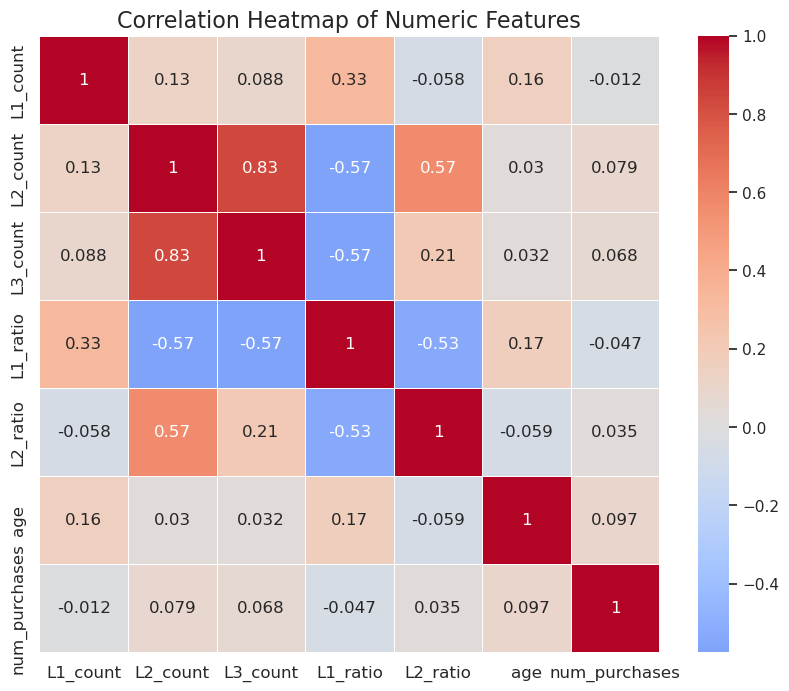

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Selecting relevant numeric columns for correlation analysis
numeric_cols = ['L1_count', 'L2_count', 'L3_count', 'L1_ratio', 'L2_ratio', 'age', 'num_purchases']

# selecting numeric columns
sample_df = sampled_df.select(numeric_cols)

# To create a correlation matrix for all columns
correlation_matrix = []
for col1 in numeric_cols:
    corr_row = []
    for col2 in numeric_cols:
        corr_value = sample_df.stat.corr(col1, col2)
        corr_row.append(corr_value)
    correlation_matrix.append(corr_row)

# To plot the correlation heatmap without using pandas
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            xticklabels=numeric_cols, yticklabels=numeric_cols, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Correlation Heatmap of Numeric Features

The heatmap visualizes the correlation between various numeric features in the dataset. The color intensity represents the strength of correlation, with values ranging from -1 to 1. Positive correlations (red) indicate that two variables increase together, while negative correlations (blue) suggest that as one increases, the other decreases. For example, `L2_count` and `L3_count` are highly correlated (0.83), showing a strong relationship between medium and low intent actions.

#### Discussion:
This heatmap helps identify the relationships between customer behavior metrics and other attributes such as age and the number of purchases. It shows that `L1_ratio` and `L2_ratio` are negatively correlated with `L2_count` and `L3_count`, indicating that high-intent actions decrease as medium and low-intent actions increase. Understanding these correlations helps guide feature selection for machine learning models, ensuring more meaningful insights while reducing redundancy caused by highly correlated features.


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>


### Feature Selection Discussion

Based on the exploratory data analysis from Part 1.2, certain features demonstrate stronger correlations with fraudulent behavior than others. The goal is to use these insights to select features that will be most impactful for machine learning models, while avoiding irrelevant or redundant features that could add noise.

#### Features to Keep:
- **L1_ratio, L2_ratio, L1_count, L2_count, L3_count**: These features capture the intensity and frequency of different customer actions, such as adding products to carts and completing purchases. As shown in the correlation heatmap, `L1_ratio` and `L2_ratio` demonstrate varying behavior between fraudulent and non-fraudulent transactions, suggesting their importance for detecting fraudulent activities.
- **num_purchases**: This feature gives insights into the customer's overall transaction history. Fraudsters may behave differently than regular customers in terms of transaction volumes.
- **age**: While age does not show a strong correlation in isolation, it could interact with other features in meaningful ways, such as how age groups relate to fraud probability.

#### Features to Remove:
- **geolocation**: Although geolocation data can provide insights, the latitude and longitude are not directly interpretable or impactful without additional context (such as clustering locations), which isn't feasible within this scope. Hence, this feature is removed.
- **session_id**: This feature is a unique identifier for each session and does not provide any meaningful information for model training.

#### Transformations:
- **Fraud Label Transformation**: Transforming the `fraud_status` column into a binary format (1 for fraud, 0 for non-fraud) will enable the classification models to use it effectively as the target variable.

The selected features and transformations aim to create a balanced, interpretable, and impactful feature set to build an effective fraud detection model.


In [13]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, StandardScaler
from pyspark.sql.functions import col

# Indexing categorical columns (if any) like 'gender' and 'fraud_status'
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_indexed", handleInvalid="skip")
fraud_status_indexer = StringIndexer(inputCol="fraud_status", outputCol="fraud_status_indexed", handleInvalid="skip")

# OneHotEncoding for 'gender' (optional based on use case)
gender_encoder = OneHotEncoder(inputCol="gender_indexed", outputCol="gender_encoded")

# VectorAssembler for numerical columns (including new/created columns)
numerical_columns = ["L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "age", "num_purchases"]

# To assemble numerical columns into a feature vector
assembler = VectorAssembler(inputCols=numerical_columns + ["gender_encoded"], outputCol="features")

# Scaling the numerical features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# To create an intermediate DataFrame where you can apply all transformations
final_df = feature_df.select(numerical_columns + ["gender", "fraud_status"])

# Assembling necessary transformers for both classification and K-means
transformation_stages = [gender_indexer, gender_encoder, assembler, scaler]

# Preparing the data for both use cases
prepared_df = final_df


In [14]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline

# To define the Random Forest classifier (RF) with the prepared features and label
rf_classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="fraud_status_indexed", predictionCol="rf_prediction")

# To define the Gradient-Boosted Tree classifier (GBT)
gbt_classifier = GBTClassifier(featuresCol="scaled_features", labelCol="fraud_status_indexed", predictionCol="gbt_prediction")


In [15]:
from pyspark.ml import Pipeline

# Pipeline for Random Forest
rf_pipeline = Pipeline(stages=[gender_indexer, gender_encoder, fraud_status_indexer, assembler, scaler, rf_classifier])

# Pipeline for Gradient-Boosted Trees
gbt_pipeline = Pipeline(stages=[gender_indexer, gender_encoder, fraud_status_indexer, assembler, scaler, gbt_classifier])


In [16]:
# To split the sampled data into training (70%) and testing (30%) sets
train_df, test_df = sampled_df.randomSplit([0.7, 0.3], seed = 10)

# To display the number of rows in each dataset
print(f"Training set: {train_df.count()} rows")
print(f"Testing set: {test_df.count()} rows")


Training set: 48422 rows
Testing set: 21150 rows


### 2.4 Training and evaluating models  


In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Training the Random Forest model using the RF pipeline
rf_model = rf_pipeline.fit(train_df)

# Training the Gradient-Boosted Tree model using the GBT pipeline
gbt_model = gbt_pipeline.fit(train_df)

# Using the trained models to predict the testing data
rf_predictions = rf_model.transform(test_df)
gbt_predictions = gbt_model.transform(test_df)

# To define an evaluator and using binary classification evaluator to measure the model performance based on the AUC (Area Under the ROC Curve)
rf_evaluator = BinaryClassificationEvaluator(labelCol="fraud_status_indexed", rawPredictionCol="rf_prediction", metricName="areaUnderROC")
gbt_evaluator = BinaryClassificationEvaluator(labelCol="fraud_status_indexed", rawPredictionCol="gbt_prediction", metricName="areaUnderROC")

# To evaluate the Random Forest model
rf_auc = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

# To evaluate the Gradient-Boosted Tree model
gbt_auc = gbt_evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Tree AUC: {gbt_auc}")

# To display some predictions from both models for review
rf_predictions.select("scaled_features", "fraud_status_indexed", "rf_prediction").show(5)
gbt_predictions.select("scaled_features", "fraud_status_indexed", "gbt_prediction").show(5)


Random Forest AUC: 0.9639466528645012
Gradient-Boosted Tree AUC: 0.9997215753771388
+--------------------+--------------------+-------------+
|     scaled_features|fraud_status_indexed|rf_prediction|
+--------------------+--------------------+-------------+
|[0.12364134570620...|                 0.0|          0.0|
|[-0.2956021928895...|                 0.0|          0.0|
|[-0.7148457314853...|                 0.0|          0.0|
|[-0.2956021928895...|                 0.0|          0.0|
|[-0.2956021928895...|                 0.0|          0.0|
+--------------------+--------------------+-------------+
only showing top 5 rows

+--------------------+--------------------+--------------+
|     scaled_features|fraud_status_indexed|gbt_prediction|
+--------------------+--------------------+--------------+
|[0.12364134570620...|                 0.0|           0.0|
|[-0.2956021928895...|                 0.0|           0.0|
|[-0.7148457314853...|                 0.0|           0.0|
|[-0.2956021928

In [18]:
from pyspark.sql import functions as F

# Define a threshold for classification 
threshold = 0.5

# Creating a column for binary predictions based on the threshold
rf_predictions = rf_predictions.withColumn("rf_predicted_label", F.when(F.col("rf_prediction") >= threshold, 1).otherwise(0))
gbt_predictions = gbt_predictions.withColumn("gbt_predicted_label", F.when(F.col("gbt_prediction") >= threshold, 1).otherwise(0))

# TP, TN, FP, FN calculations for Random Forest
rf_tp = rf_predictions.filter((F.col("rf_predicted_label") == 1) & (F.col("fraud_status_indexed") == 1)).count()
rf_tn = rf_predictions.filter((F.col("rf_predicted_label") == 0) & (F.col("fraud_status_indexed") == 0)).count()
rf_fp = rf_predictions.filter((F.col("rf_predicted_label") == 1) & (F.col("fraud_status_indexed") == 0)).count()
rf_fn = rf_predictions.filter((F.col("rf_predicted_label") == 0) & (F.col("fraud_status_indexed") == 1)).count()

# TP, TN, FP, FN calculations for Gradient-Boosted Trees
gbt_tp = gbt_predictions.filter((F.col("gbt_predicted_label") == 1) & (F.col("fraud_status_indexed") == 1)).count()
gbt_tn = gbt_predictions.filter((F.col("gbt_predicted_label") == 0) & (F.col("fraud_status_indexed") == 0)).count()
gbt_fp = gbt_predictions.filter((F.col("gbt_predicted_label") == 1) & (F.col("fraud_status_indexed") == 0)).count()
gbt_fn = gbt_predictions.filter((F.col("gbt_predicted_label") == 0) & (F.col("fraud_status_indexed") == 1)).count()

# Display results for both models
print(f"Random Forest: TP={rf_tp}, TN={rf_tn}, FP={rf_fp}, FN={rf_fn}")
print(f"Gradient-Boosted Trees: TP={gbt_tp}, TN={gbt_tn}, FP={gbt_fp}, FN={gbt_fn}")


Random Forest: TP=298, TN=19745, FP=9, FN=23
Gradient-Boosted Trees: TP=321, TN=19743, FP=11, FN=0


In [19]:
from pyspark.sql import functions as F

def calculate_metrics(predictions_df, label_col, predicted_col):
    # Confusion Matrix Elements
    TN = predictions_df.filter(F.col(predicted_col) == 0).filter(F.col(label_col) == 0).count()
    TP = predictions_df.filter(F.col(predicted_col) == 1).filter(F.col(label_col) == 1).count()
    FN = predictions_df.filter(F.col(predicted_col) == 0).filter(F.col(label_col) == 1).count()
    FP = predictions_df.filter(F.col(predicted_col) == 1).filter(F.col(label_col) == 0).count()

    # Show Confusion Matrix
    predictions_df.groupBy(label_col, predicted_col).count().show()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Return metrics as a dictionary
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

# Usage for Random Forest
rf_metrics = calculate_metrics(rf_predictions, "fraud_status_indexed", "rf_predicted_label")
print(f"Random Forest Metrics: {rf_metrics}")

# Usage for Gradient-Boosted Trees
gbt_metrics = calculate_metrics(gbt_predictions, "fraud_status_indexed", "gbt_predicted_label")
print(f"Gradient-Boosted Trees Metrics: {gbt_metrics}")

+--------------------+------------------+-----+
|fraud_status_indexed|rf_predicted_label|count|
+--------------------+------------------+-----+
|                 1.0|                 0|   23|
|                 0.0|                 0|19745|
|                 1.0|                 1|  298|
|                 0.0|                 1|    9|
+--------------------+------------------+-----+

Random Forest Metrics: {'Accuracy': 0.9984059775840598, 'Precision': 0.9706840390879479, 'Recall': 0.9283489096573209, 'F1-Score': 0.9490445859872613}
+--------------------+-------------------+-----+
|fraud_status_indexed|gbt_predicted_label|count|
+--------------------+-------------------+-----+
|                 0.0|                  0|19743|
|                 1.0|                  1|  321|
|                 0.0|                  1|   11|
+--------------------+-------------------+-----+

Gradient-Boosted Trees Metrics: {'Accuracy': 0.9994520547945206, 'Precision': 0.9668674698795181, 'Recall': 1.0, 'F1-Sco

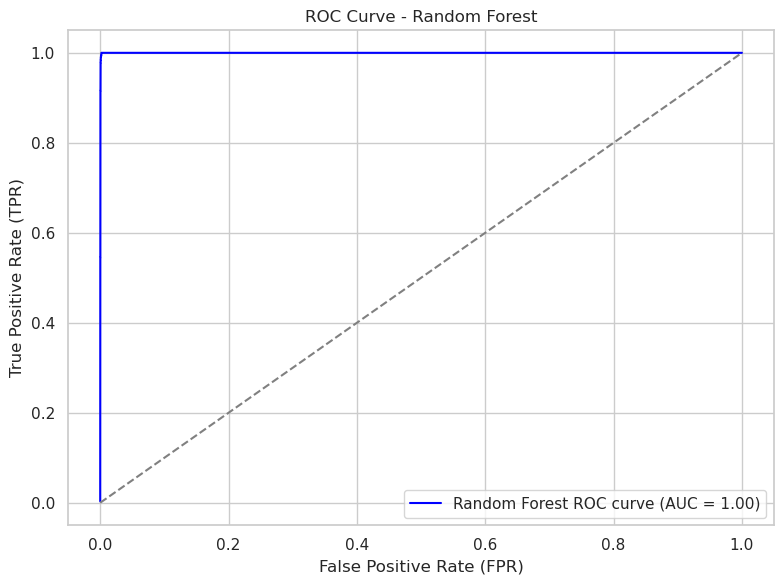

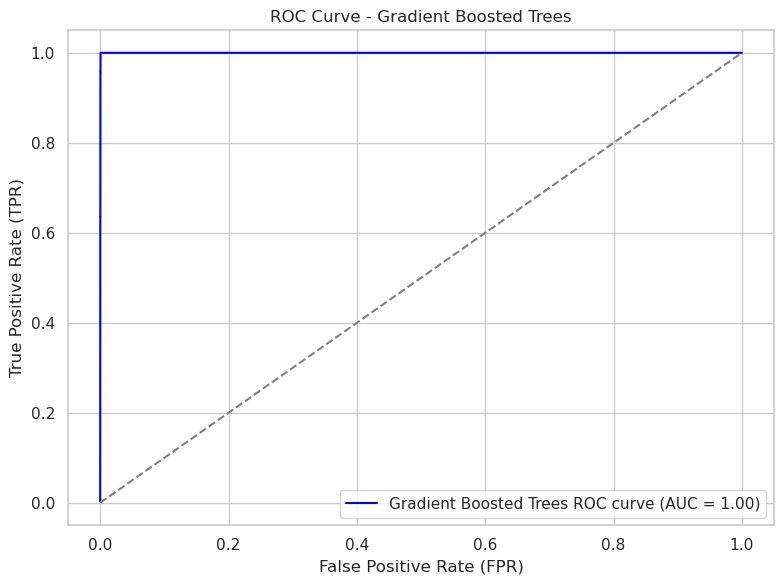

In [20]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define function to calculate and plot ROC curve
def plot_roc_curve_from_summary(predictions_df, label_col, prob_col, model_name):
    # Binary Classification Evaluator for AUC calculation
    evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prob_col, metricName="areaUnderROC")
    auc_value = evaluator.evaluate(predictions_df)
    
    # Extract probabilities from the predictions DataFrame
    roc_data = predictions_df.select(prob_col, label_col).rdd.map(
        lambda row: (float(row[prob_col][1]), float(row[label_col]))
    ).collect()
    
    # Sort by probability (descending order)
    roc_data = sorted(roc_data, key=lambda x: x[0], reverse=True)
    
    # Initialize counters and lists for FPR, TPR
    tpr, fpr = [], []
    pos_count = sum([x[1] for x in roc_data])
    neg_count = len(roc_data) - pos_count
    tp, fp = 0, 0

    for prob, label in roc_data:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / pos_count)
        fpr.append(fp / neg_count)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} ROC curve (AUC = {auc_value:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Baseline
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for Random Forest
plot_roc_curve_from_summary(rf_predictions, "fraud_status_indexed", "probability", "Random Forest")

# Example usage for Gradient-Boosted Trees
plot_roc_curve_from_summary(gbt_predictions, "fraud_status_indexed", "probability", "Gradient Boosted Trees")


### **Model Comparison: Random Forest vs. Gradient-Boosted Trees**

#### **Random Forest:**
- **Accuracy**: 99.84%
- **Precision**: 97.07% (Indicates fewer false positives.)
- **Recall**: 92.83% (Captures most fraudulent transactions.)
- **F1-Score**: 94.90% (Balances precision and recall well.)

#### **Gradient-Boosted Trees:**
- **Accuracy**: 99.95% (Slightly higher than Random Forest.)
- **Precision**: 96.69% (Slightly lower than Random Forest.)
- **Recall**: 100% (Perfectly identifies all fraudulent transactions.)
- **F1-Score**: 98.32% (Better overall balance between precision and recall.)

### **Conclusion:**
- **Gradient-Boosted Trees** excels in **recall** and overall **F1-Score**, making it ideal for scenarios where identifying all fraudulent transactions is critical.
- **Random Forest** performs better in **precision**, reducing false positives, and offers a strong balance of metrics.
  
For higher fraud detection sensitivity, **Gradient-Boosted Trees** is the better choice. If minimizing false positives is more important, go with **Random Forest**.


In [21]:
# Determine the best model based on AUC
model_type, best_model, save_path = ("Random Forest", rf_model, "best_rf_model") if rf_auc > gbt_auc else ("Gradient-Boosted Trees", gbt_model, "best_gbt_model")

# Inform which model performed better
print(f"{model_type} performed better based on AUC.")

# Save the best model to the appropriate path
best_model.save(save_path)

# Confirm the model has been saved
print(f"The selected model has been successfully saved at: {save_path}")


Gradient-Boosted Trees performed better based on AUC.
The selected model has been successfully saved at: best_gbt_model


### Part 3. Customer Clustering and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  


In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F

# Selecting relevant features for clustering
clustering_columns = ["L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio", "age", "num_purchases"]

# Filling null values with 0 or other appropriate values
clustering_data_filled = feature_df.fillna(0, subset=clustering_columns)

# Assemble features into a vector for K-Means
assembler = VectorAssembler(inputCols=clustering_columns, outputCol="features")

# Transform the DataFrame to include feature vector
clustering_data = assembler.transform(clustering_data_filled)

# Show assembled features
clustering_data.select("features").show(5, truncate=False)


+-----------------------------------+
|features                           |
+-----------------------------------+
|[3.0,4.0,9.0,18.75,25.0,20.0,129.0]|
|[3.0,1.0,3.0,42.86,14.29,49.0,5.0] |
|[12.0,0.0,3.0,80.0,0.0,29.0,6.0]   |
|[3.0,2.0,3.0,37.5,25.0,31.0,43.0]  |
|[3.0,4.0,7.0,21.43,28.57,27.0,18.0]|
+-----------------------------------+
only showing top 5 rows



In [23]:
# Setting the K value (initially 2, but this can be changed based on analysis)
kmeans = KMeans(k=2, seed=10, featuresCol="features", predictionCol="cluster_prediction")

# To train the KMeans model
kmeans_model = kmeans.fit(clustering_data)

# To make predictions (assign clusters to customers)
clustered_customers = kmeans_model.transform(clustering_data)

# To show the clustered customers with their assigned cluster
clustered_customers.select("features", "cluster_prediction").show(5)


+--------------------+------------------+
|            features|cluster_prediction|
+--------------------+------------------+
|[3.0,4.0,9.0,18.7...|                 0|
|[3.0,1.0,3.0,42.8...|                 1|
|[12.0,0.0,3.0,80....|                 1|
|[3.0,2.0,3.0,37.5...|                 1|
|[3.0,4.0,7.0,21.4...|                 1|
+--------------------+------------------+
only showing top 5 rows



In [24]:
# To evaluate clustering by computing Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster_prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_customers)
print(f"Silhouette Score for KMeans Clustering: {silhouette_score:.4f}")


Silhouette Score for KMeans Clustering: 0.7846


In [25]:
# To group by clusters and explore statistics for each group
clustered_customers.groupBy("cluster_prediction").agg(
    F.mean("L1_ratio").alias("avg_L1_ratio"),
    F.mean("L2_ratio").alias("avg_L2_ratio"),
    F.mean("age").alias("avg_age"),
    F.mean("num_purchases").alias("avg_num_purchases")
).show()


+------------------+-----------------+-----------------+------------------+------------------+
|cluster_prediction|     avg_L1_ratio|     avg_L2_ratio|           avg_age| avg_num_purchases|
+------------------+-----------------+-----------------+------------------+------------------+
|                 1|33.29547784209675|19.13024105227694|26.726329611703882|35.727917720822795|
|                 0|30.80463643975541|20.26831507996305| 27.90452985012141|178.96162605710458|
+------------------+-----------------+-----------------+------------------+------------------+



In [26]:
# To test different values of K to find the best number of clusters
for k in range(2, 6):  # You can adjust the range as needed
    kmeans = KMeans(k=k, seed=10, featuresCol="features", predictionCol="cluster_prediction")
    kmeans_model = kmeans.fit(clustering_data)
    clustered_customers = kmeans_model.transform(clustering_data)
    silhouette_score = evaluator.evaluate(clustered_customers)
    print(f"Silhouette Score for K={k}: {silhouette_score:.4f}")


Silhouette Score for K=2: 0.7846
Silhouette Score for K=3: 0.6322
Silhouette Score for K=4: 0.5459
Silhouette Score for K=5: 0.4533


### **Explanation of K-Means Clustering Process**

1. **Feature Selection**:  
   We selected key behavioral features such as interaction counts (L1, L2, L3), ratios, age, and number of purchases to group customers based on their actions.

2. **K-Means Clustering**:  
   The K-Means algorithm was applied to these features to group customers into clusters. Each customer was assigned to a cluster based on their behavioral similarities.

3. **Evaluation**:  
   The **Silhouette Score** was used to evaluate the quality of clustering. A higher score indicates better-defined clusters. By experimenting with different values of **K**, we identified that **K=2** gave the best score (0.7846), indicating well-separated clusters.

4. **Cluster Analysis**:  
   We explored each cluster by calculating statistics (e.g., average L1/L2 ratios, age, and number of purchases). This helps us understand the characteristics of customers in each group, providing insights into potential patterns of fraud behavior.


## References:

1. Dwork, C., & Roth, A. (2014). The Algorithmic Foundations of Differential Privacy. *Foundations and Trends in Theoretical Computer Science*, 9(3–4), 211–407. https://doi.org/10.1561/0400000042

2. Sweeney, L. (2002). k-Anonymity: A Model for Protecting Privacy. *International Journal of Uncertainty, Fuzziness and Knowledge-Based Systems*, 10(5), 557–570. https://doi.org/10.1142/S0218488502001648

3. Apple Inc. (2021). *App Store privacy labels*. Apple Developer Documentation. https://developer.apple.com/app-store/app-privacy-details/

4. BBC News. (2023, April 4). TikTok fined £12.7m for misusing children’s data in UK. *BBC*. https://www.bbc.com/news/uk-65175902

5. European Commission. (2020). *General Data Protection Regulation (GDPR)*. https://gdpr.eu/

6. LastPass. (2022, December 22). *Notice of recent security incident*. LastPass. https://blog.lastpass.com/posts/2022/12/notice-of-security-incident

7. Uber Technologies, Inc. (2022, September 16). *Uber data breach statement*. Uber Newsroom. https://www.uber.com/newsroom/security-update
